In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import numpy as np
from wordcloud import WordCloud

In [3]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Disable unnecessary components for speed

In [5]:
# Load Dataset
imdb = pd.read_excel("Imdb.xlsx")

In [7]:
# Data Exploration
print("Dataset Info:")
print(imdb.info())
print("\nClass Distribution:")
print(imdb['sentiment'].value_counts())
print("\nMissing Values:")
print(imdb.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing Values:
review       0
sentiment    0
dtype: int64


In [9]:
# Drop missing values if any
imdb.dropna(subset=['review', 'sentiment'], inplace=True)

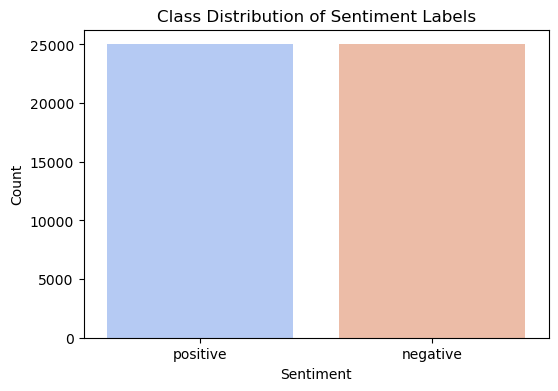

In [15]:
# Visualizing Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=imdb, x='sentiment', hue='sentiment', palette="coolwarm", legend=False)
plt.title("Class Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

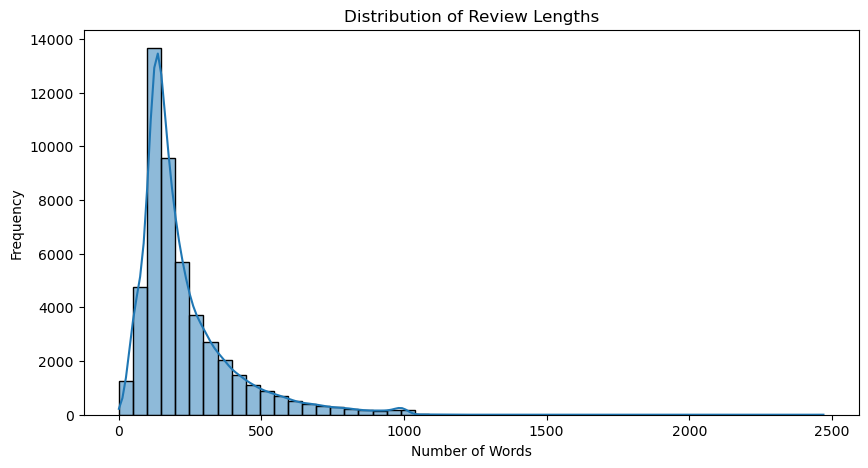

In [29]:
# Review Length Analysis
imdb['review_length'] = imdb['review'].apply(lambda x: len(str(x).split()))
imdb['char_count'] = imdb['review'].apply(lambda x: len(str(x)))
imdb['avg_word_length'] = imdb['char_count'] / imdb['review_length']
plt.figure(figsize=(10, 5))
sns.histplot(imdb['review_length'], bins=50, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

C:\Users\Asus\AppData\Local\Temp\ipykernel_20652\3528149487.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=imdb['review_length'], palette="pastel")


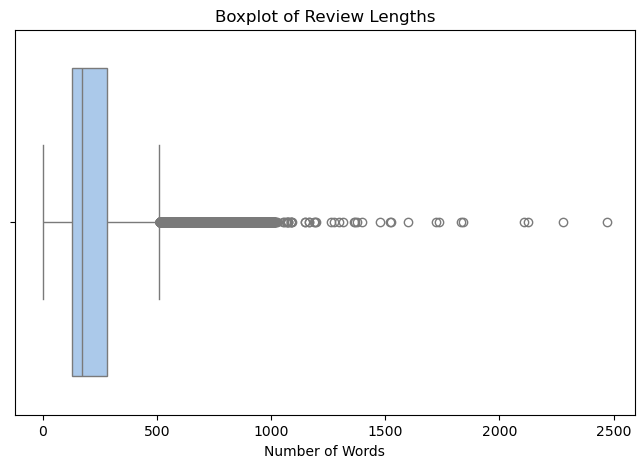

In [37]:
# Boxplot for Review Lengths
plt.figure(figsize=(8, 5))
sns.boxplot(x=imdb['review_length'], palette="pastel")
plt.title("Boxplot of Review Lengths")
plt.xlabel("Number of Words")
plt.show()

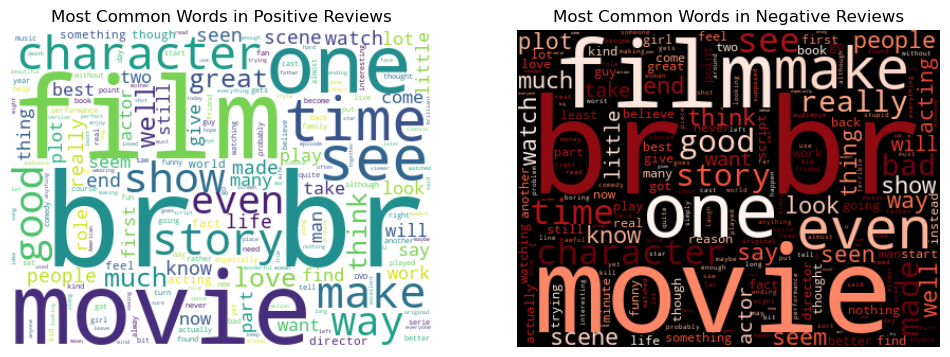

In [39]:
# Generating Word Clouds
positive_reviews = " ".join(imdb[imdb['sentiment'] == 'positive']['review'].astype(str))
negative_reviews = " ".join(imdb[imdb['sentiment'] == 'negative']['review'].astype(str))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
wordcloud_pos = WordCloud(width=400, height=300, background_color='white').generate(positive_reviews)
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Positive Reviews")

plt.subplot(1, 2, 2)
wordcloud_neg = WordCloud(width=400, height=300, background_color='black', colormap='Reds').generate(negative_reviews)
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Negative Reviews")

plt.show()

In [41]:
# Data Preprocessing
def preprocess_text(text):
    text = str(text)
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters and digits
    text = text.lower().strip()  # Convert to lowercase and trim spaces
    doc = nlp(text)  # Process text with SpaCy
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]  # Lemmatization & stopword removal
    return " ".join(tokens)  # Return preprocessed text as a string

In [43]:
# Apply preprocessing with progress bar
tqdm.pandas()
imdb['cleaned_review'] = imdb['review'].progress_apply(preprocess_text)

100%|████████████████████████████████████████████████████████████████████████████| 50000/50000 [37:51<00:00, 22.01it/s]


In [45]:
# Feature Engineering
bow_vectorizer = CountVectorizer(max_features=1000)
X_bow = bow_vectorizer.fit_transform(imdb['cleaned_review'])

tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(imdb['cleaned_review'])

y = imdb['sentiment'].map({'negative': 0, 'positive': 1})

In [47]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

In [49]:
# Model Development
models = {
    "Logistic Regression": LogisticRegression(max_iter=200),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=50),
    "SVM": SVC(kernel='linear', probability=True)
}

In [51]:
# Train and Evaluate Models
results = {}
for name, model in tqdm(models.items(), desc="Training Models"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    }
    print(f"\n{name} Classification Report:\n", classification_report(y_test, y_pred))

Training Models:  25%|████████████████▊                                                  | 1/4 [00:00<00:00,  7.12it/s]


Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      5000
           1       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.81      0.83      5000
           1       0.82      0.84      0.83      5000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000



Training Models:  75%|██████████████████████████████████████████████████▎                | 3/4 [00:49<00:18, 18.43s/it]


Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83      5000
           1       0.83      0.82      0.82      5000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000



Training Models: 100%|██████████████████████████████████████████████████████████████████| 4/4 [26:47<00:00, 401.97s/it]


SVM Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.85      0.86      5000
           1       0.85      0.87      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



In [53]:
# Display Results
results_df = pd.DataFrame(results).T
print("\nModel Performance:")
print(results_df)


Model Performance:
                     Accuracy  Precision  Recall  F1-Score   ROC-AUC
Logistic Regression    0.8591   0.852820  0.8680  0.860343  0.936422
Naive Bayes            0.8284   0.818588  0.8438  0.831003  0.909837
Random Forest          0.8250   0.829081  0.8188  0.823908  0.905656
SVM                    0.8597   0.853270  0.8688  0.860965  0.935402


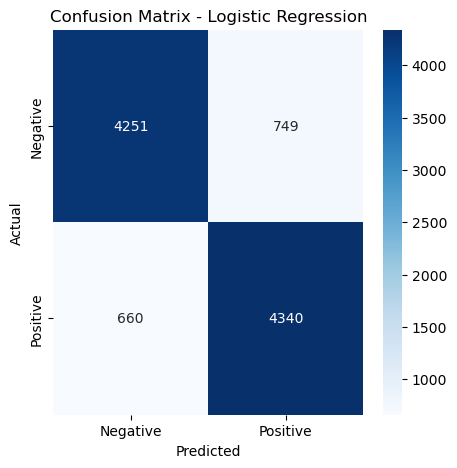

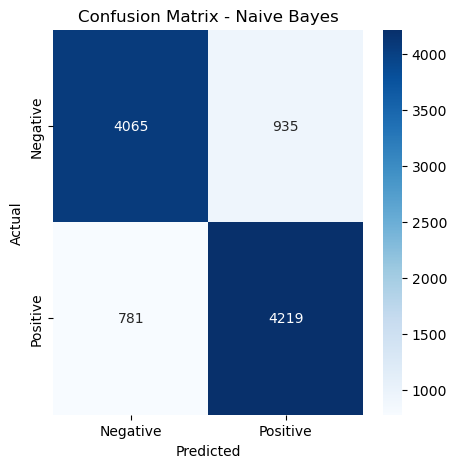

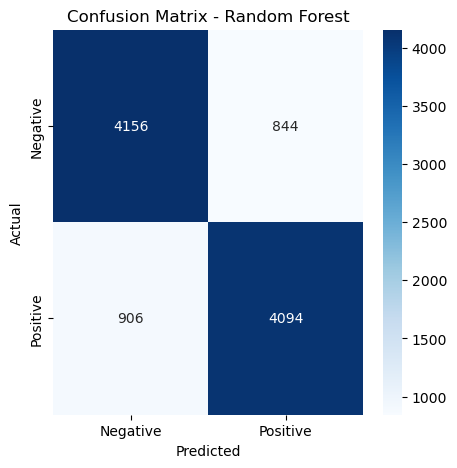

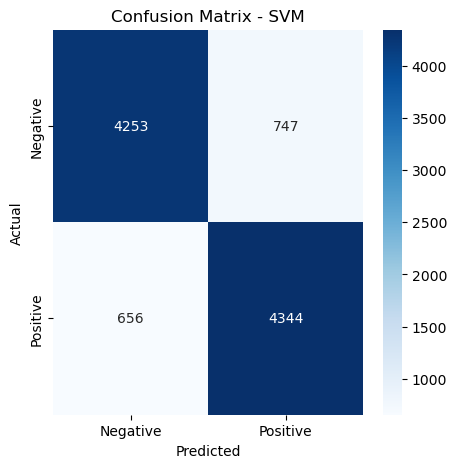

In [55]:
# Model Evaluation
for name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()